# Continuous Control

This project entails training a double-jointed arm in order to move to target locations. A reward of +0.1 is given to the agent for every step the agent's hand is within the goal location. This project aims to train the agent so that it is able to maintain its position at the target areas as long as possible. 

#### 1. Import Packages

The following imports are necessary in order to run the environment and train the agent. The agent built to solve this the given task is based on DDPG (Deep Deterministic Policy Gradient) method. Unlike DQN and DDQN which were presented in the previous project, DDPG is a policy based method as opposed to value based method. 

In [ ]:
from unityagents import UnityEnvironment
from collections import deque
from ddpgarm import DDPG

import matplotlib.pyplot as plt
import numpy as np
import torch
import time as t_

#### 2. Setting Up Environment

The environment is provided by UnityEnvironment called Reacher.exe. This file is saved under the folder `Reacher_Windows_x86_64/Reacher.exe` since all of the training is done on a Windows 64-bit machine. The graphics is disabled during the training. Next, the brain of the environment is set before resetting the environment prior to exploring and/or training. 

The following information, however, is important to note:

1. Actions are consisted of vectors with four numbers corresponding to the torque applicable to two joints:
    - The entry of the action vector should be a number between -1 and 1
2. There are 33 observation spaces including:
    - Arm's position
    - Arm's rotation
    - Arm's velocity
    - Arm's angular velocity

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe', no_graphics=True) # 20 agents

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20


The DDPG agent is trained on the environment with 20 identical agents.

Both of these agents will have the following neural network architecture:

1. Actor Network
    - `hidden_layer_1 = 128`, with `ReLU` activation function
    - `hidden_layer_2 = 128`, with `ReLU` activation function
    - `output_layer`, with `tanh` activation function
    
2. Critic Network
    - `hidden_layer_1 = 128`, with `ReLU` activation function
    - `hidden_layer_2 = 128`, with `ReLU` activation function
    - `output_layer`, without activation function

In [3]:
ddpg_agent = DDPG(n_state=state_size, n_action=action_size, num_agents=num_agents, seed=0)

#### 3. Define model_train() Function to Train the Agent

The following function is written to train the agent through a series of episodes. The total number of episodes is set to be 2000, with maximum of 1000 steps per episode. 

The scores for each episode is recorded at the end of every loop. The stopping criteria of the agent trained is an average score of 30 or more for the past 100 consecutive episodes. This average score is stored within a list of avg_scores with maximum length of deque as 100. 

The function returns both the scores list and average scores list (to be plotted later).

In [4]:
def model_train(num_episodes=2000, total_time=1000, num_agents=num_agents):
    
    '''Function to train the DDPG agent on the Unity environment
    
    Params:
        num_episodes (int)       : total number of episodes
        total_time (int)         : number of steps taken by the agent
        
    Return:
        scores (list)            : scores attained by the group of agents each episode
        avg_scores (list)        : agents' mean scores per consecutive episodes
    '''
    
    avg_scores = deque(maxlen=100)
    scores = []
    avg_100 = []
    for episode in range(1, num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = np.zeros(num_agents)
        start = t_.time()
        for t in range(total_time):
            actions = []
            for agent in range(num_agents):
                ddpg_agent.reset()
                actions.append(ddpg_agent.select_action(states[agent]))
            env_info = env.step(actions)[brain_name]
            states_ = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            for agent in range(num_agents):
                ddpg_agent.step(states[agent], actions[agent], rewards[agent], states_[agent], dones[agent])
            for _ in range(num_updates):
                ddpg_agent.check_learn()
            states = states_
            score += rewards
            if np.any(dones):
                break
        end_t = round(t_.time() - start,2)
        scores.append(np.mean(score))
        avg_scores.append(np.mean(score))
        avg_100.append(np.mean(avg_scores))
        print('\rEpisode {} \tScore: {:.2f} \tAverage Score: {:.2f} \tRuntime: {} seconds'.format(episode, np.mean(score), np.mean(avg_scores), end_t), end='')
        if episode % 100 == 0:
            print('\rEpisode {} \tScore: {:.2f} \tAverage Score: {:.2f} \tRuntime: {} seconds'.format(episode, np.mean(score), np.mean(avg_scores), end_t))
        if np.mean(avg_scores) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!'.format(episode))
            print('Average Final Score: {:.2f}'.format(np.mean(avg_scores)))
            if num_agents == 1:
                torch.save(ddpg_agent.act_local.state_dict(), 'saved_model/DDPG_actor_single_agent.pth')
                torch.save(ddpg_agent.crit_local.state_dict(), 'saved_model/DDPG_critic_single_agent.pth')
                break
            else:
                torch.save(ddpg_agent.act_local.state_dict(), 'saved_model/DDPG_actor_multi_agents.pth')
                torch.save(ddpg_agent.crit_local.state_dict(), 'saved_model/DDPG_critic_multi_agents.pth')
                break
            print('Model weights have been saved!')
    return scores, avg_100

In [5]:
ddpg_scores, ddpg_avg_scores = model_train()

Episode 100 	Score: 38.88 	Average Score: 16.88 	Runtime: 69.42 seconds
Episode 137 	Score: 39.08 	Average Score: 30.30 	Runtime: 65.69 seconds
Environment solved in 137 episodes!
Average Final Score: 30.30


The results show that the agent is able to solve the environment with average final score of 30.30 after 137 episodes.

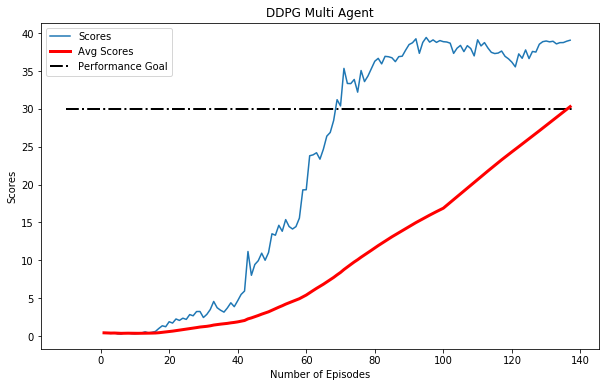

In [8]:
index = [i+1 for i in range(len(ddpg_scores))]
plt.figure(figsize=(10,6))
plt.plot(index, ddpg_scores, label='Scores')
plt.hlines(30, -10, len(ddpg_scores)+1, colors = 'k', linestyle='dashdot', linewidth=2, label='Performance Goal')
plt.plot(index, ddpg_avg_scores, 'r', linewidth=3, label='Avg Scores')
plt.title('DDPG Multi Agent')
plt.xlabel('Number of Episodes')
plt.ylabel('Scores')
plt.axis('tight')
plt.legend()
plt.savefig('figures/ddpg_multi_agent.png')
plt.show()

#### 4. Discussion and Observations

The plots available suggest that DDPG has a solid consistency in terms of learning from the environment. Both the scores and average scores seem to be consistently increasing until 65-70. In which after that many episodes, the maximum training score of the agent hovers around 35-40 while the average scores for the past (up to) 100 scores are steadily growing to 30.  

In the process of completing the project, numerous combinations of hyperparameters were implemented for DDPG. Among 30 or so combinations, this hyperparameters were found to be the most optimal:

1. epsilon = 1.0
2. eps_min = 0.01
3. eps_decay = 1e-6
4. gamma = 0.99
5. tau = 0.001
6. learning rate
    - 0.0001 for Actor
    - 0.0003 for Critic
7. Deep QNetwork:
    - hidden_layer_1 = 128, with ReLU
    - hidden_layer_2 = 128, with ReLU
    - output_layer
        - tanh activation function for Actor
        - no activation function for Critic
8. targetUpdateNet = 20
9. num_update = 10
9. seed = 0

One limiting factor in exploring all of these hyperparameters is definitely the time it takes to train the agent. Therefore, the model can be improved further by either tweaking the DDPG Agent's hyperparameters or the architecture of the neural network itself, e.g. learning rate, number of hidden layers, number of neurons per hidden layer, activation function (LeakyReLU instead of ReLU), etc.

In [7]:
env.close()